In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# read data from the driver csv file
URL = 'https://drive.google.com/file/d/16ZSKEHFlF0QVnrdUu3Zb2yJg1t95awkn/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
df = pd.read_csv(path)
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [3]:
df.tail()

,DATE,PRCP,TMAX,TMIN,RAIN
25546,2017-12-10,0.0,49,34,False
25547,2017-12-11,0.0,49,29,False
25548,2017-12-12,0.0,46,32,False
25549,2017-12-13,0.0,48,34,False
25550,2017-12-14,0.0,50,36,False


In [4]:
# Baseline model
df["RAIN"].value_counts(normalize=True)

False    0.573352
True     0.426648
Name: RAIN, dtype: float64

### **Discovering the PRCP**

In [5]:
df['PRCP'].describe()

count    25548.000000
mean         0.106222
std          0.239031
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max          5.020000
Name: PRCP, dtype: float64

In [6]:
df['PRCP'].value_counts()

0.00    14648
0.01      933
0.02      707
0.03      493
0.04      428
        ...  
2.49        1
2.18        1
2.20        1
2.70        1
2.95        1
Name: PRCP, Length: 207, dtype: int64

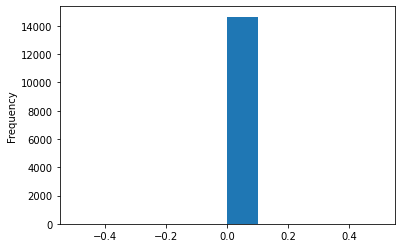

In [7]:
df[df['RAIN'] == False]['PRCP'].plot(kind='hist')

### **Discovering the TMax**

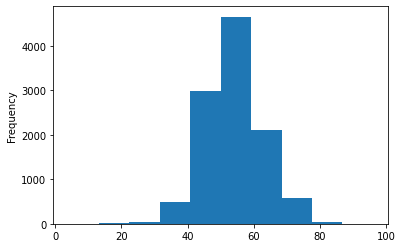

In [8]:
df[df['RAIN'] == True]['TMAX'].plot(kind='hist')

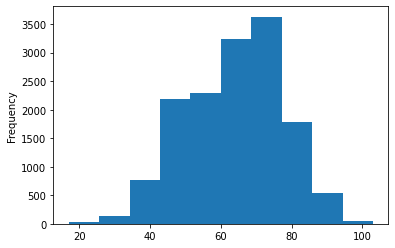

In [9]:
df[df['RAIN'] == False]['TMAX'].plot(kind='hist')

### TMin

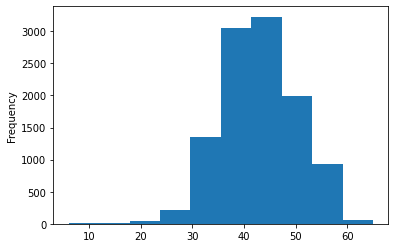

In [10]:
df[df['RAIN'] == True]['TMIN'].plot(kind='hist')

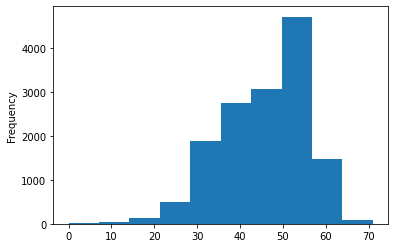

In [11]:
df[df['RAIN'] == False]['TMIN'].plot(kind='hist')

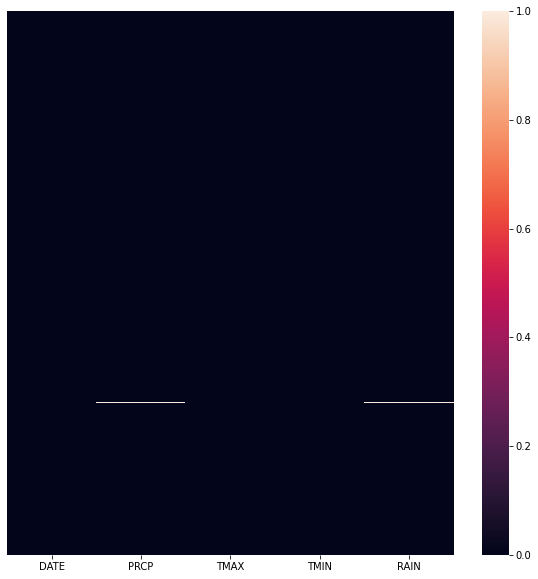

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.isnull(df), yticklabels=False)

In [13]:
# Find the null values in PRCP column
df[pd.isnull(df["PRCP"])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [14]:
# Find nulls in the rain column

df[pd.isnull(df["RAIN"])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


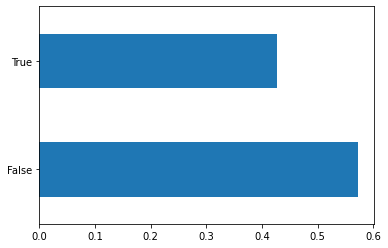

In [15]:
# Look at target class distribution
df["RAIN"].value_counts(normalize=True).plot(kind="barh")

In [16]:
def RAIN_INSERTION(cols):
    """
    Impute False where NaN values are present
    """
    
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return False
    else:
        return RAIN
    

def PRCP_INSERTION(col):
    """
    Insert the Mean of PRCP where NaN values are present
    """
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [17]:
# Apply the Functions
df["RAIN"] = df[["RAIN"]].apply(RAIN_INSERTION, axis=1) # axis =1 means apply to columns 
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)


### Coding a Heuristic by hand and evaluating

- If it rained yesterday or the day before then it will rain today and Precipitation grater than 

In [18]:
def heuristic(df):
    """
    Simple heuristic:
    
    If it rained the past two days then predict rain else predict no rain
    
    Frist two rows are predicted false be default
    """
    
    preds = []
    
    for x in range(len(df)):
        # If first two rows then predict false
        if x<2:
            preds.append(False)
        else:
            # If either of last two days == True then predict True
            condation_1 = (df.iloc[x-1]["RAIN"] == True) | (df.iloc[x-2]["RAIN"] == True) 
            condation_2 = (df.iloc[x-1]["PRCP"] > 0.001) | (df.iloc[x-2]["PRCP"]  > 0.001) 
            condation_3 = ((df.iloc[x-1]["TMAX"] > 30) & (df.iloc[x-1]["TMAX"] <= 70 )) | ((df.iloc[x-2]["TMAX"] > 30) & (df.iloc[x-2]["TMAX"] <= 70 ))
            condation_4 = ((df.iloc[x-1]["TMIN"] > 25) & (df.iloc[x-1]["TMIN"] < 50 )) | ((df.iloc[x-2]["TMIN"] > 25) & (df.iloc[x-2]["TMIN"] < 50 ))

            if condation_1  & condation_2 & condation_3 & condation_4:
                preds.append(True)
            else:
                preds.append(False)
    return preds
    

In [19]:
df["preds"] = heuristic(df)


In [20]:
# Determine Accuracy

# Create function to to find values

def calc_confuse(df):
    
    "Calculate all possible results of a confusion matrix"

    # Hold all possible values and set to zero
    FP = np.zeros(len(df))
    TP = np.zeros(len(df))
    FN = np.zeros(len(df))
    TN = np.zeros(len(df))
    
    for x in range(len(df)):
        
        # True Positive
        if (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == True):
            TP[x] = 1
        # True Negative
        elif (df["RAIN"].iloc[x] == False) & (df["preds"].iloc[x] == False):
            TN[x] = 1
        # False Negative
        elif (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == False):
            FN[x] = 1
        # False Positive
        else:
            FP[x] = 1
    
    return FP, TP, FN, TN

In [21]:
# Extract results and create columns for each
w,x,y,z = calc_confuse(df)

df["FP"] = w
df["TP"] = x
df["FN"] = y
df["TN"] = z

# Look at 10 random rows to determin accuracy
df.sample(10)

,DATE,PRCP,TMAX,TMIN,RAIN,preds,FP,TP,FN,TN
4163,1959-05-26,0.03,59,47,True,True,0.0,1.0,0.0,0.0
687,1949-11-18,0.06,53,45,True,False,0.0,0.0,1.0,0.0
24600,2015-05-09,0.00,80,49,False,False,0.0,0.0,0.0,1.0
11649,1979-11-23,0.00,48,38,False,True,1.0,0.0,0.0,0.0
2470,1954-10-06,0.00,70,48,False,False,0.0,0.0,0.0,1.0
4897,1961-05-29,0.03,68,51,True,True,0.0,1.0,0.0,0.0
23881,2013-05-20,0.00,67,49,False,False,0.0,0.0,0.0,1.0
20425,2003-12-03,0.05,47,36,True,True,0.0,1.0,0.0,0.0
19403,2001-02-14,0.00,44,30,False,False,0.0,0.0,0.0,1.0
3697,1958-02-14,0.03,47,41,True,True,0.0,1.0,0.0,0.0


In [22]:
# Heuristic Model
# the accuracy is improve .
(sum(df["TP"]) + sum(df["TN"]))/ len(df)

0.6816171578411804

### Predict PRCP

Create a heuristic model to predict the PRCP column in the Seattle Weather data and calculate the **Mean Squared Error** from your predictions. Did you do better than predicting the mean value for the PRCP column?

In [24]:
# Crate random regression prediction to test regression cost functions

print(f"Regression Mean Baseline: {df['PRCP'].mean()}")

# Createing a random number generator
rng = np.random.default_rng(42)

# Assign random predictions to dataframe for demo purposes
df["preds_r"] = rng.uniform(0.01, 0.5, len(df))

# Predict mean baseline
df["baseline"] = df["PRCP"].mean()

df.head()

Regression Mean Baseline: 0.10622162204477957


,DATE,PRCP,TMAX,TMIN,RAIN,preds,FP,TP,FN,TN,preds_r,baseline
0,1948-01-01,0.47,51,42,True,False,0.0,0.0,1.0,0.0,0.389238,0.106222
1,1948-01-02,0.59,45,36,True,False,0.0,0.0,1.0,0.0,0.225050,0.106222
2,1948-01-03,0.42,45,35,True,True,0.0,1.0,0.0,0.0,0.430713,0.106222
3,1948-01-04,0.31,45,34,True,True,0.0,1.0,0.0,0.0,0.351710,0.106222
4,1948-01-05,0.17,45,32,True,True,0.0,1.0,0.0,0.0,0.056147,0.106222
